In [1]:
# TODO
# windowing seems off 

In [1]:
import pathlib
import random
import string
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
import matplotlib.pyplot as plt

from Helpers import create_rolling_windows 

In [2]:
'''
text_file = keras.utils.get_file(
    fname="spa-eng.zip",
    origin="http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip",
    extract=True,
)
text_file = pathlib.Path(text_file).parent / "spa-eng" / "spa.txt"
'''

'\ntext_file = keras.utils.get_file(\n    fname="spa-eng.zip",\n    origin="http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip",\n    extract=True,\n)\ntext_file = pathlib.Path(text_file).parent / "spa-eng" / "spa.txt"\n'

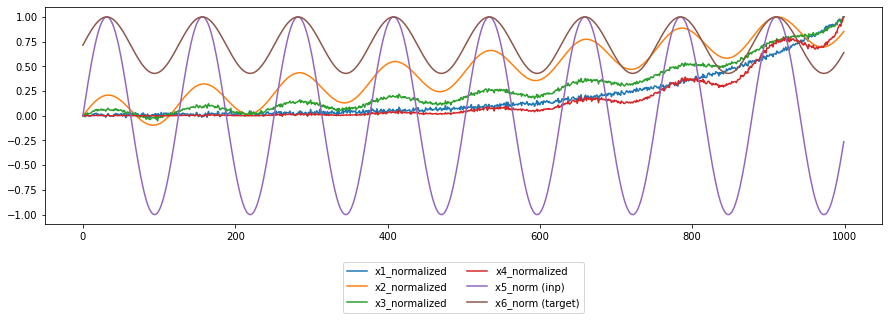

In [3]:
# Create surrogate sample data 

surrogate_samples = 1000
t = np.linspace(0, 50, surrogate_samples)

# inputs, outputs 
x1 = np.exp(0.1 * t) + np.random.normal(0, 2, surrogate_samples)
x2 = 10 * np.sin(t) + t 
x3 = x1 + x2 
x4 = x1 * x2 / 100 
x5 = np.sin(t) * 0.8
x6 = x5 * 0.2 + 0.4

x1_factor = np.max(np.abs(x1))
x2_factor = np.max(np.abs(x2))
x3_factor = np.max(np.abs(x3))
x4_factor = np.max(np.abs(x4))
x5_factor = np.max(np.abs(x5))
x6_factor = np.max(np.abs(x6))


# normalize per time series
x1_normalized = x1 / x1_factor
x2_normalized = x2 / x2_factor
x3_normalized = x3 / x3_factor
x4_normalized = x4 / x4_factor
x5_normalized = x5 / x5_factor
x6_normalized = x6 / x6_factor


plt.figure(figsize=(15, 4))
plt.plot(range(len(x1_normalized)), x1_normalized, label='x1_normalized')
plt.plot(range(len(x2_normalized)), x2_normalized, label='x2_normalized')
plt.plot(range(len(x3_normalized)), x3_normalized, label='x3_normalized')
plt.plot(range(len(x4_normalized)), x4_normalized, label='x4_normalized')
plt.plot(range(len(x5_normalized)), x5_normalized, label='x5_norm (inp)')
plt.plot(range(len(x6_normalized)), x6_normalized, label='x6_norm (target)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

Shape surrogate pairs: (980, 2, 21)


'\nwith open(text_file) as f:\n    lines = f.read().split("\n")[:-1]\ntext_pairs = []\nfor line in lines:\n    eng, spa = line.split("\t")\n    spa = "[start] " + spa + " [end]"\n    text_pairs.append((eng, spa))\n'

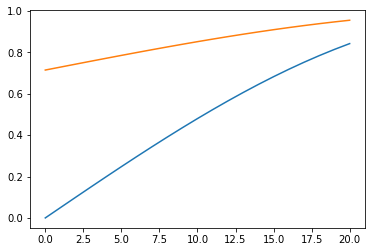

In [28]:
# Create input and target datasets 

'''
seq_length = 20
batch_size = 128 
input_dataset = timeseries_dataset_from_array(data=x5_normalized,targets=None, sequence_length = seq_length, sequence_stride = 1, batch_size = batch_size, shuffle = False)
target_dataset = timeseries_dataset_from_array(data=x6_normalized,targets=None, sequence_length = seq_length, sequence_stride = 1, batch_size = batch_size, shuffle = False)

# check data is correctly cut 
for batch in zip(input_dataset, target_dataset):
    inputs, targets = batch
    
    assert np.array_equal(inputs[0], x5_normalized[:seq_length])
    assert np.array_equal(targets[1], x6_normalized[1:seq_length + 1])
    break
'''    


# datas.as_numpy_iterator())[-1]

# generate pairs (old way)

'''
x5_normalized = np.arange(200) # / 400

print(x5_normalized)

x6_normalized = np.arange(400,600) #/ 600

print(x6_normalized)

'''


surrogate_data = np.array([x5_normalized,x6_normalized]).T
surrogate_pairs = create_rolling_windows(surrogate_data,21)
surrogate_pairs = np.swapaxes(surrogate_pairs,1,2)
print("Shape surrogate pairs: " + str(surrogate_pairs.shape))

plt.plot(surrogate_pairs[0][0])
plt.plot(surrogate_pairs[0][1])


'''
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    eng, spa = line.split("\t")
    spa = "[start] " + spa + " [end]"
    text_pairs.append((eng, spa))
'''

In [29]:
val_frac = 0.15 # amount of val; amount of test 

random.shuffle(surrogate_pairs)
num_val_samples = int(val_frac * len(surrogate_pairs))
num_train_samples = len(surrogate_pairs) - 2 * num_val_samples
train_pairs = surrogate_pairs[:num_train_samples]
val_pairs = surrogate_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = surrogate_pairs[num_train_samples + num_val_samples :]

print(f"{len(surrogate_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")


'''
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")
'''

980 total pairs
686 training pairs
147 validation pairs
147 test pairs


'\nrandom.shuffle(text_pairs)\nnum_val_samples = int(0.15 * len(text_pairs))\nnum_train_samples = len(text_pairs) - 2 * num_val_samples\ntrain_pairs = text_pairs[:num_train_samples]\nval_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]\ntest_pairs = text_pairs[num_train_samples + num_val_samples :]\n\nprint(f"{len(text_pairs)} total pairs")\nprint(f"{len(train_pairs)} training pairs")\nprint(f"{len(val_pairs)} validation pairs")\nprint(f"{len(test_pairs)} test pairs")\n'

In [30]:
# Split pairs into inp and target 
train_inp_seqs = [pair[0] for pair in train_pairs]
train_target_seqs = [pair[1] for pair in train_pairs]
val_inp_seqs = [pair[0] for pair in val_pairs]
val_target_seqs = [pair[1] for pair in val_pairs]


print(np.shape(train_inp_seqs))
print(np.shape(train_target_seqs))
print(np.shape(val_inp_seqs))
print(np.shape(val_target_seqs))

batch_size = 128
sequence_length = 20
vocab_size = 15000

'''
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocab_size = 15000
sequence_length = 20
batch_size = 64


def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


eng_vectorization = TextVectorization(
    max_tokens=vocab_size, output_mode="int", output_sequence_length=sequence_length,
)
spa_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_eng_texts = [pair[0] for pair in train_pairs]
train_spa_texts = [pair[1] for pair in train_pairs]
eng_vectorization.adapt(train_eng_texts)
spa_vectorization.adapt(train_spa_texts)
'''

(686, 21)
(686, 21)
(147, 21)
(147, 21)


'\nstrip_chars = string.punctuation + "¿"\nstrip_chars = strip_chars.replace("[", "")\nstrip_chars = strip_chars.replace("]", "")\n\nvocab_size = 15000\nsequence_length = 20\nbatch_size = 64\n\n\ndef custom_standardization(input_string):\n    lowercase = tf.strings.lower(input_string)\n    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")\n\n\neng_vectorization = TextVectorization(\n    max_tokens=vocab_size, output_mode="int", output_sequence_length=sequence_length,\n)\nspa_vectorization = TextVectorization(\n    max_tokens=vocab_size,\n    output_mode="int",\n    output_sequence_length=sequence_length + 1,\n    standardize=custom_standardization,\n)\ntrain_eng_texts = [pair[0] for pair in train_pairs]\ntrain_spa_texts = [pair[1] for pair in train_pairs]\neng_vectorization.adapt(train_eng_texts)\nspa_vectorization.adapt(train_spa_texts)\n'

In [31]:
        
def make_dataset(input_seqs,target_seqs):
    ###input_seqs, target_seqs = zip(*pairs)
    #print(input_seqs)
    #print(target_seqs)
    ###input_seqs = list(input_seqs)
    ###target_seqs = list(target_seqs)
    
    input_seqs = np.array(input_seqs).astype(float)
    target_seqs = np.array(target_seqs).astype(float)
    
    print(input_seqs)
    
    # Create dataset with inp sequence <-> target sequence pairs (both have length sequence_length)
    dataset = tf.data.Dataset.from_tensor_slices((input_seqs, target_seqs)) # tuple makes sure that inp matches correct target

    # batch 
    dataset = dataset.batch(batch_size)
    
    # format input/ outputs omitting last elem for decoder input and skipping first elem for target 
    # idea: instead of "word by word", show everything and do not omit first or last 
    dataset = dataset.map(format_dataset)
    
    return dataset.shuffle(2048).prefetch(16).cache()



def format_dataset(inp, target):
    #inp = inp_vectorization(inp)
    #target = target_vectorization(target)
    
    print("format")
    for elem in inp:
        print(elem)
    print(np.shape(inp))
    print(np.shape(target))
    
    # transformer architecture -> proceed word by word
    # full target sequence for input (i.e. 20)
    # 0 to N for decoder input (i.e. 20)
    # 1 to N-1 for target -> shifted by one (i.e. 20)
    # TODO: Make rolling windows more clever, i.e. no need to cut inp
    
    return ({"encoder_inputs": inp[:, :-1], "decoder_inputs": target[:, :-1],}, target[:, 1:])
    #return ({"encoder_inputs": inp, "decoder_inputs": target[:, :-1],}, target)
    
    #return ({"encoder_inputs": inp, "decoder_inputs": target}, target)


'''
def format_dataset(eng, spa):
    eng = eng_vectorization(eng)
    spa = spa_vectorization(spa)
    return ({"encoder_inputs": eng, "decoder_inputs": spa[:, :-1],}, spa[:, 1:])


def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()
'''

train_ds = make_dataset(train_inp_seqs,train_target_seqs)
val_ds = make_dataset(val_inp_seqs,val_target_seqs)

[[ 0.          0.05002916  0.09993302 ...  0.7838866   0.81396829
   0.84201141]
 [ 0.05002916  0.09993302  0.1495866  ...  0.81396829  0.84201141
   0.84201141]
 [ 0.09993302  0.1495866   0.19886554 ...  0.84201141  0.84201141
   0.38978711]
 ...
 [-0.89512754 -0.48320219  0.06917137 ...  0.99732918 -0.78859269
   0.90846248]
 [-0.48320219  0.06917137 -0.99378003 ... -0.78859269  0.90846248
  -0.01156024]
 [ 0.06917137 -0.99378003 -0.99333304 ...  0.90846248 -0.01156024
  -0.25514987]]
format
Tensor("while/TensorArrayV2Read/TensorListGetItem:0", shape=(21,), dtype=float64)
(None, 21)
(None, 21)
[[-0.99378003 -0.99333304 -0.9597     ... -0.01156024 -0.25514987
   0.79564857]
 [-0.99333304 -0.9597      0.40737418 ... -0.25514987  0.79564857
   0.88997624]
 [-0.9597      0.40737418  0.42493489 ...  0.79564857  0.88997624
   0.70981836]
 ...
 [ 0.87919597  0.98001323 -0.69059488 ...  0.67929853 -0.78867652
   0.41084897]
 [ 0.98001323 -0.69059488 -0.50660077 ... -0.78867652  0.41084897
  

In [32]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (46, 20)
inputs["decoder_inputs"].shape: (46, 20)
targets.shape: (46, 20)


In [33]:


class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        
        print("Encoder SHape")
        print(self.layernorm_2(proj_input + proj_output))
        return self.layernorm_2(proj_input + proj_output)

    
    

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        
        # dummy 
        vocab_size = 20
        
        ### no need for token embedding 
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim 
        )
        ###
        
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        
        ### no need for token embedding 
        embedded_tokens = self.token_embeddings(inputs)
        ### 
        
        embedded_positions = self.position_embeddings(positions)
        
        '''
        print(embedded_tokens)
        print(embedded_positions)
        print(inputs)
        print()
        print(embedded_positions + inputs)
        '''
        
        return embedded_tokens + embedded_positions # original
        #return tf.expand_dims(embedded_positions, axis=0)
        #return embedded_positions + inputs # no need for token embedding, instead add actual numbers 
        
    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    
    
    

class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        
        print("Decoder Shaper")
        print(self.layernorm_3(out_2 + proj_output))
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)



In [43]:
embed_dim = 256
latent_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="float64", name="encoder_inputs")
x_encoder = PositionalEmbedding(sequence_length, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x_encoder)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="float64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x_decoder = PositionalEmbedding(sequence_length, embed_dim)(decoder_inputs)
x_decoder = TransformerDecoder(embed_dim, latent_dim, num_heads)(x_decoder, encoded_seq_inputs)
x_decoder = layers.Dropout(0.5)(x_decoder)

# decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x) # orig
#decoder_outputs = layers.Dense(sequence_length, activation="softmax")(x_decoder)
decoder_outputs = layers.Dense(20, activation="softmax")(x_decoder)




#decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])



transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)



Encoder SHape
Tensor("transformer_encoder_8/layer_normalization_41/add:0", shape=(None, None, 256), dtype=float32)
Decoder Shaper
Tensor("transformer_decoder_8/layer_normalization_44/add:0", shape=(None, None, 256), dtype=float32)
Decoder Shaper
Tensor("model_16/transformer_decoder_8/layer_normalization_44/add:0", shape=(None, None, 256), dtype=float32)


In [44]:
#error_sq = tf.math.squared_difference(y_pred, y_true)

def custom_mse(y_true, y_pred):
    
    print(y_true)
    print(y_pred)
    
    #squared_difference = tf.square(y_true - y_pred[:,0,:])
    squared_difference = tf.square(y_true - y_pred[:,:,-1]) # last entry of each
    
    return tf.reduce_mean(squared_difference)  # Note the `axis=-1`


In [45]:
epochs = 30  # This should be at least 30 for convergence

transformer.summary()
transformer.compile(
    "rmsprop", loss=custom_mse, metrics=["accuracy"] # sparse_categorical_crossentropy # mse
)
transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
positional_embedding_16 (Positi (None, None, 256)    10240       encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
transformer_encoder_8 (Transfor (None, None, 256)    3155456     positional_embedding_16[0][0]    
________________________________________________________________________________________

In [51]:
train_inp_seqs[0]
train_target_seqs[0]

array([0.71428571, 0.72857976, 0.74283801, 0.75702474, 0.77110444,
       0.78504184, 0.79880202, 0.81235054, 0.82565346, 0.83867746,
       0.85138992, 0.863759  , 0.87575373, 0.88734407, 0.89850099,
       0.90919654, 0.91940394, 0.92909762, 0.93825332, 0.94684808,
       0.9548604 ])

In [62]:

max_decoded_sequence_length = 20

def decode_sequence(input_sequence):
    decoded_sequence = np.array([])
    for i in range(max_decoded_sequence_length):
        
        predictions = transformer([input_sequence, decoded_sequence])
        
        sampled_token = np.max(predictions[0, i, :]) # verify this
        decoded_sequence = decoded_sequence.add(sampled_token)
    
    return decoded_sequence

print(decode_sequence(train_inp_seqs[0][:-1]))


InvalidArgumentError: Index out of range using input dim 1; input has only 1 dims [Op:StridedSlice] name: transformer/transformer_encoder_8/strided_slice/

In [ ]:
spa_vocab = spa_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = spa_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence


test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(30):
    input_sentence = random.choice(test_eng_texts)
    translated = decode_sequence(input_sentence)